# Searching major star catalogs and Simbad by position or name with `vo_conesearch`

## Authors
P. L. Lim

## Learning Goals
* Perform a cone search around M31 using a web service.
* Write the result out to a LaTeX table.
* Perform a SIMBAD query using the cone search result.
* Extract metadata from the cone search catalog.
* Sort cone search results by angular distance.
* Search multiple cone search services at once (synchronously and asynchronously).
* Estimate the run time of a cone search.

## Keywords
astroquery, table, coordinates, units, vo_conesearch, LaTex, SIMBAD, matplotlib

## Summary
This tutorial desmonstrates the [Cone Search](http://astroquery.readthedocs.io/en/latest/vo_conesearch/vo_conesearch.html) subpackage, which allows you to query a catalog of astronomical sources and obtain those that lie within a cone of a given radius around the given position. 

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
matplotlib
numpy



### Imports

In [2]:
# Python standard library
import time
import warnings

# Third-party software
import numpy as np

# Astropy
from astropy import coordinates as coord
from astropy import units as u
from astropy.table import Table

# Astroquery. This tutorial requires 0.3.5 or greater.
import astroquery
from astroquery.simbad import Simbad
from astroquery.vo_conesearch import conf, conesearch, vos_catalog

# Set up matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

If you are running an older version of `astroquery`, you might need to set `vos_baseurl` yourself, as follows.

In [3]:
from astropy.utils import minversion

if not minversion(astroquery, '0.3.10'):
    conf.vos_baseurl = 'https://astroconda.org/aux/vo_databases/'

To start, it might be useful to list the available Cone Search catalogs first. By default, catalogs that pass nightly validation are included. Validation is hosted by Space Telescope Science Institute (STScI).

In [4]:
conesearch.list_catalogs()

['2MASS All-Sky Catalog of Point Sources 1',
 'Gaia DR2 5',
 'Guide Star Catalog 2.3 Cone Search 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 2',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 3',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 4',
 'The HST Guide Star Catalog, Version 1.1 1',
 'The HST Guide Star Catalog, Version 1.2 1',
 'The HST Guide Star Catalog, Version GSC-ACT 1',
 'The PMM USNO-A1.0 Catalogue 1',
 'The USNO-A2.0 Catalogue 1',
 'The USNO-B1.0 Catalog 2',
 'Two Micron All Sky Survey (2MASS) 1',
 'Two Micron All Sky Survey (2MASS) 2']

Next, let's pick an astronomical object of interest. For example, M31.

In [5]:
c = coord.SkyCoord.from_name('M31', frame='icrs')
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (10.6847083, 41.26875)>


By default, a basic Cone Search goes through the list of catalogs and *stops* at the first one that returns non-empty VO table. Let's search for objects within 0.1 degree around M31. You will see a lot of warnings that were generated by VO table parser but ignored by Cone Search service validator. VO compliance enforced by Cone Search providers is beyond the control of `astroquery.vo_conesearch` package.

The result is an [Astropy table](http://astropy.readthedocs.io/en/stable/table/index.html).

In [6]:
result = conesearch.conesearch(c, 0.1 * u.degree)

Trying http://vizier.unistra.fr/viz-bin/conesearch/II/246/out?


In [7]:
print('First non-empty table returned by', result.url)
print('Number of rows is', len(result))

First non-empty table returned by http://vizier.unistra.fr/viz-bin/conesearch/II/246/out?
Number of rows is 2008


In [8]:
print(result)

   _r     RAJ2000    DEJ2000   errMaj errMin ... scanKey coaddKey coadd Opt
            deg        deg     arcsec arcsec ...                           
-------- ---------- ---------- ------ ------ ... ------- -------- ----- ---
0.088860  10.699043  41.180546   0.08   0.07 ...   69157  1590592    44 Opt
0.099056  10.692956  41.169888   0.08   0.07 ...   69157  1590592    44 Opt
0.096789  10.696697  41.172382   0.20   0.20 ...   69157  1590592    44 Opt
0.091839  10.699687  41.177605   0.24   0.21 ...   69157  1590592    44 Opt
0.086295  10.699178  41.183144   0.36   0.34 ...   69157  1590592    44 Opt
0.095003  10.711372  41.175888   0.24   0.24 ...   69157  1590592    44 Opt
0.091538  10.712260  41.179588   0.21   0.18 ...   69157  1590592    44 Opt
0.094139  10.714217  41.177265   0.08   0.07 ...   69157  1590592    44 Opt
0.090449  10.728262  41.184441   0.20   0.19 ...   69157  1590592    44 Opt
     ...        ...        ...    ...    ... ...     ...      ...   ... ...
0.097966  10

This table can be manipulated like any other Astropy table; e.g., re-write the table into LaTeX format.

In [9]:
result.write('my_result.tex', format='ascii.latex', overwrite=True)

You can now use your favorite text editor to open the `my_result.tex` file, but here, we are going to read it back into another Astropy table.

Note that the extra `data_start=4` option is necessary due to the non-roundtripping nature of LaTeX reader/writer (see [astropy issue 5205](https://github.com/astropy/astropy/issues/5205)).

In [10]:
result_tex = Table.read('my_result.tex', format='ascii.latex', data_start=4)
print(result_tex)

   _r     RAJ2000   DEJ2000  errMaj errMin ... extKey scanKey coaddKey coadd Opt
-------- --------- --------- ------ ------ ... ------ ------- -------- ----- ---
 0.08886 10.699043 41.180546   0.08   0.07 ...     --   69157  1590592    44 Opt
0.099056 10.692956 41.169888   0.08   0.07 ...     --   69157  1590592    44 Opt
0.096789 10.696697 41.172382    0.2    0.2 ...     --   69157  1590592    44 Opt
0.091839 10.699687 41.177605   0.24   0.21 ...     --   69157  1590592    44 Opt
0.086295 10.699178 41.183144   0.36   0.34 ...     --   69157  1590592    44 Opt
0.095003 10.711372 41.175888   0.24   0.24 ...     --   69157  1590592    44 Opt
0.091538  10.71226 41.179588   0.21   0.18 ...     --   69157  1590592    44 Opt
0.094139 10.714217 41.177265   0.08   0.07 ...     --   69157  1590592    44 Opt
0.090449 10.728262 41.184441    0.2   0.19 ...     --   69157  1590592    44 Opt
0.095957 10.735452  41.18071   0.24   0.23 ...     --   69157  1590592    44 Opt
     ...       ...       ...

Cone Search results can also be used in conjuction with other types of queries.
For example, you can query SIMBAD for the first entry in your result above.

In [11]:
# Due to the unpredictability of external services,
# The first successful query result (above) might differ
# from run to run.
#
# CHANGE THESE VALUES to the appropriate RA and DEC
# column names you see above, if necessary.
# These are for http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&
ra_colname = 'ra'
dec_colname = 'dec'

In [12]:
# Don't run this cell if column names above are invalid.
if ra_colname in result.colnames and dec_colname in result.colnames:
    row = result[0]
    simbad_obj = coord.SkyCoord(ra=row[ra_colname]*u.deg, dec=row[dec_colname]*u.deg)
    print('Searching SIMBAD for\n{}\n'.format(simbad_obj))
    simbad_result = Simbad.query_region(simbad_obj, radius=5*u.arcsec)
    print(simbad_result)
else:
    print('{} or {} not in search results. Choose from: {}'.format(
        ra_colname, dec_colname, ' '.join(result.colnames)))

ra or dec not in search results. Choose from: _r RAJ2000 DEJ2000 errMaj errMin errPA _2MASS Jmag Jcmsig e_Jmag Jsnr Hmag Hcmsig e_Hmag Hsnr Kmag Kcmsig e_Kmag Ksnr Qflg Rflg Bflg Cflg Ndet prox pxPA pxCntr Xflg Aflg Cntr Hemis Date Scan GLON GLAT Xscan _tab1_36 Jpsfchi Hpsfchi Kpsfchi Jstdap e_Jstdap Hstdap e_Hstdap Kstdap e_Kstdap edgeNS edgeEW edge dup use opt Dopt PAopt Bmag Rmag Nopt extKey scanKey coaddKey coadd Opt


Now back to Cone Search... You can extract metadata of this Cone Search catalog.

In [13]:
my_db = vos_catalog.get_remote_catalog_db(conf.conesearch_dbname)
try:
    my_cat = my_db.get_catalog_by_url(result.url)
except AttributeError:
    my_cat = my_db.get_catalog_by_url(result.url + '&')
print(my_cat.dumps())

{
    "authenticated_only": 0,
    "cap_description": "Cone search capability for table II/246/out (2MASS Point Source Catalogue, output (on a total of 470,992,970 sources))",
    "cap_index": 4,
    "cap_type": "conesearch",
    "content_level": "research",
    "content_type": "catalog",
    "created": "1/10/2008 11:19:42 PM",
    "creator_seq": "",
    "duplicatesIgnored": 4,
    "intf_index": 1,
    "intf_role": "std",
    "intf_type": "vs:paramhttp",
    "ivoid": "ivo://cds.vizier/ii/246",
    "mirror_url": "https://vizier.iucaa.in/viz-bin/conesearch/II/246/out?#http://vizieridia.saao.ac.za/viz-bin/conesearch/II/246/out?",
    "query_type": "",
    "reference_url": "http://cdsarc.unistra.fr/cgi-bin/cat/II/246",
    "region_of_regard": NaN,
    "res_description": "The Two Micron All Sky Survey (2MASS) project is designed to close the gap between our current technical capability and our knowledge of the near-infrared sky. In addition to providing a context for the interpretation of r

If you have a favorite catalog in mind, you can also perform Cone Search only on that catalog. A list of available catalogs can be obtained by calling `conesearch.list_catalogs()`, as mentioned above.

In [14]:
try:
    result = conesearch.conesearch(
        c, 0.1 * u.degree, catalog_db='The USNO-A2.0 Catalogue (Monet+ 1998) 1')
except Exception as e:  
    # We provide a cached version of the result table in case the query fails 
    # due to an intermittent server-side issue, or if you do not have an 
    # internet connection
    result = Table.read('usno-A2-result.fits')

In [15]:
print('Number of rows is', len(result))

Number of rows is 3


Let's explore the 3 rows of astronomical objects found within 0.1 degree of M31 in the given catalog and sort them by increasing distance. For this example, the VO table has several columns that might include:

* `_r` = Angular distance (in degrees) between object and M31
* `USNO-A2.0` = Catalog ID of the object
* `RAJ2000` = Right ascension of the object (epoch=J2000)
* `DEJ2000` = Declination of the object (epoch=J2000)

Note that column names, meanings, order, etc. might vary from catalog to catalog.

In [16]:
col_names = result.colnames
print(col_names)

['_r', 'USNO-A2.0', 'RAJ2000', 'DEJ2000', 'ACTflag', 'Mflag', 'Bmag', 'Rmag', 'Epoch']


In [17]:
# Before sort
print(result)

   _r      USNO-A2.0    RAJ2000    DEJ2000   ACTflag Mflag Bmag Rmag  Epoch  
  deg                     deg        deg                   mag  mag     yr   
-------- ------------- ---------- ---------- ------- ----- ---- ---- --------
0.094265 1275-00425574  10.595878  41.335328      --    -- 19.8 17.4 1953.773
0.098040 1275-00427192  10.639945  41.360845      --    -- 19.4 18.4 1953.773
0.063280 1275-00429939  10.712834  41.209109       A    -- 99.9 11.2       --


In [18]:
# After sort
result.sort('_r')
print(result)

   _r      USNO-A2.0    RAJ2000    DEJ2000   ACTflag Mflag Bmag Rmag  Epoch  
  deg                     deg        deg                   mag  mag     yr   
-------- ------------- ---------- ---------- ------- ----- ---- ---- --------
0.063280 1275-00429939  10.712834  41.209109       A    -- 99.9 11.2       --
0.094265 1275-00425574  10.595878  41.335328      --    -- 19.8 17.4 1953.773
0.098040 1275-00427192  10.639945  41.360845      --    -- 19.4 18.4 1953.773


You can also convert the distance to arcseconds.

In [19]:
result['_r'].to(u.arcsec)

<Quantity [227.808, 339.354, 352.944] arcsec>

What if you want *all* the results from *all* the catalogs? And you also want to suppress all the VO table warnings and informational messages?

__Warning: This can be time and resource intensive.__

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    all_results = conesearch.search_all(c, 0.1 * u.degree, verbose=False)

In [21]:
for url, tab in all_results.items():
    print(url, 'returned', len(tab), 'rows')

http://vizier.unistra.fr/viz-bin/conesearch/II/246/out? returned 2008 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/345/gaia2? returned 1752 rows
http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23 returned 4028 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/220/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/254/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/255/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/243/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/252/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/284/out? returned 5 rows
http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_psc returned 2008 rows
http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_xsc returned 25 rows


In [22]:
# Pick out the first one with "I/220" in it.
i220keys = [k for k in all_results if 'I/220' in k]
my_favorite_result = all_results[i220keys[0]]
print(my_favorite_result)

   _r       GSC      RAJ2000   DEJ2000  PosErr ... Plate  Epoch   Mult Versions
                       deg       deg    arcsec ...          yr                 
-------- ---------- --------- --------- ------ ... ----- -------- ---- --------
0.063449 0280102008  10.71207  41.20873    0.2 ...  0738 1985.877    F  GSC-all
0.043453 0280102015  10.68782  41.22536    0.2 ...  0738 1985.877    F  GSC-all
0.096170 0280102081  10.80558  41.23727    0.2 ...  0738 1985.877    F  GSC-all
0.066633 0280102017  10.60025  41.24853    0.2 ...  0738 1985.877    F  GSC-all
0.082097 0280502180  10.64539  41.34535    0.2 ...  0738 1985.877    F  GSC-all


### Asynchronous Searches

Asynchronous versions (i.e., search will run in the background) of `conesearch()` and `search_all()` are also available. Result can be obtained using the asynchronous instance's `get()` method that returns the result upon completion or after a given `timeout` value in seconds.

In [23]:
try:
    async_search = conesearch.AsyncConeSearch(
        c, 0.1 * u.degree, catalog_db='The USNO-A2.0 Catalogue (Monet+ 1998) 1')
    print('Am I running?', async_search.running())

    time.sleep(3)
    print('After 3 seconds. Am I done?', async_search.done())
    print()

    result = async_search.get(timeout=30)
    print('Number of rows returned is', len(result))
    
except Exception as e:  
    # We provide a cached version of the result table in case the query fails 
    # due to an intermittent server-side issue, or if you do not have an 
    # internet connection
    result = Table.read('usno-A2-result.fits')

Am I running? True


After 3 seconds. Am I done? True



In [24]:
async_search_all = conesearch.AsyncSearchAll(c, 0.1 * u.degree)
print('Am I running?', async_search_all.running())
print('Am I done?', async_search_all.done())
print()

all_results = async_search_all.get(timeout=60)
for url, tab in all_results.items():
    print(url, 'returned', len(tab), 'rows')

Am I running? True
Am I done? False



http://vizier.unistra.fr/viz-bin/conesearch/II/246/out? returned 2008 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/345/gaia2? returned 1752 rows
http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23 returned 4028 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/220/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/254/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/255/out? returned 5 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/243/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/252/out? returned 3 rows
http://vizier.unistra.fr/viz-bin/conesearch/I/284/out? returned 5 rows
http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_psc returned 2008 rows
http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_xsc returned 25 rows


### Estimating the Search Time

Let's predict the run time of performing Cone Search on `http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&` with a radius of 0.1 degrees. For now, the prediction assumes a very simple linear model, which might or might not reflect the actual trend.

This might take a while.

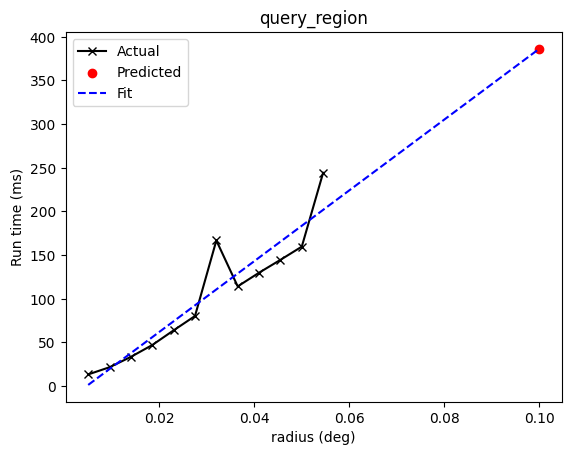

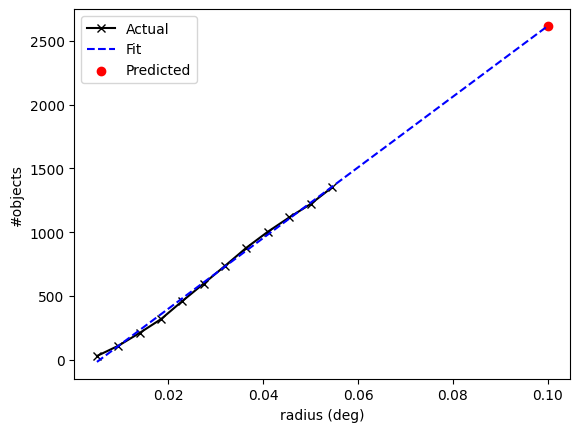

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    t_est, n_est = conesearch.predict_search(
        'http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&',
        c, 0.1 * u.degree, verbose=False, plot=True)

In [26]:
print('Predicted run time is', t_est, 'seconds')
print('Predicted number of rows is', n_est)

Predicted run time is 0.3861108281025149 seconds
Predicted number of rows is 2617


Let's get the actual run time and number of rows to compare with the prediction above. This might take a while.

As you will see, the prediction is not spot on, but it's not too shabby (at least, not when we tried it!). Note that both predicted and actual run time results also depend on network latency and responsiveness of the service provider.

In [27]:
t_real, tab = conesearch.conesearch_timer(
    c, 0.1 * u.degree,
    catalog_db='http://gsss.stsci.edu/webservices/vo/ConeSearch.aspx?CAT=GSC23&',
    verbose=False)

INFO: conesearch_timer took 0.4941830635070801 s on AVERAGE for 1 call(s). [astroquery.utils.timer]


In [28]:
print('Actual run time is', t_real, 'seconds')
print('Actual number of rows is', len(tab))

Actual run time is 0.4941830635070801 seconds
Actual number of rows is 4028
